In [189]:
import pandas as pd
import numpy as np 
import yfinance as yf
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
import warnings
warnings.simplefilter(action='ignore')

In [190]:
data = pd.read_csv('NQ.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data

,y,a1,a2,b1,b2,b3,b4,b5,b6,b7,...,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-09,0.000555,0.675009,0.67,2.029210,1.61,1.354201,0.94,2.40,18.70,80.56,...,-1.25,-2.029728,-1.92,1.65,72.17,38.37,-1.579,13.25,-3.08,-0.02
2020-01-10,-0.006665,0.012606,0.81,0.779468,2.12,0.766862,1.31,1.37,26.23,84.60,...,-0.80,-1.952923,-1.61,3.25,28.33,35.54,-1.813,13.51,-3.73,-0.95
2020-01-13,0.007542,-0.585729,-0.27,-0.086929,0.23,0.498800,0.50,1.42,-15.69,84.98,...,-2.30,-1.453885,-2.03,2.26,-1.09,28.82,-2.286,14.27,-5.64,-3.27
2020-01-14,-0.002971,0.653482,1.04,1.707098,2.14,1.053616,1.10,1.87,-14.73,88.06,...,0.66,-0.266841,-0.38,1.37,-51.36,32.75,-2.420,14.98,-4.62,-2.71
2020-01-15,0.001105,-0.207969,-0.24,-1.269340,-1.35,-1.061371,-1.11,1.73,35.38,76.77,...,2.32,2.254327,2.56,2.45,46.02,44.84,-2.038,14.63,-2.29,-0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,-0.000209,-0.984979,-0.93,-0.657744,-0.48,0.327235,0.45,2.86,-14.12,40.59,...,-1.37,-0.337247,-0.44,5.38,-11.75,34.64,-2.828,24.21,-9.41,-1.07
2024-07-29,-0.005282,0.149617,1.03,-0.338363,0.22,-0.487980,-0.81,1.60,-18.87,41.68,...,1.59,-1.367858,0.56,2.41,-31.09,38.36,-2.810,24.55,-7.78,0.26
2024-07-30,-0.016868,-0.425302,0.07,0.589971,0.13,1.015273,0.06,1.63,-13.03,42.38,...,-0.93,-0.758752,-1.00,3.89,-20.37,36.97,-2.702,24.56,-8.35,-0.96


In [98]:
stock_in_nasdaq100 = ['NVDA','SMIC','ARM','CEG','META','AVGO','NFLX','ISRG','TTD','KLAC',
                   'REGN','COST','FTNT','DASH','CTAS','MELI','AMAT','MU','AZN','PANW',
                   'TMUS','ASML','FAMG','AEP','GOOG','VRTX','GOOGL','QCOM','QCOM','TXN',
                   'ORLY','AMZN','AAPL','PYPL','CCEP','MRVL','AMGN','ADP','MSFT','ADI',
                   'VRSK','LIN','NXPI','LRCX','EA','GEHC','SNPS','KDP','INTU','ROST',
                   'AMD','CPRT','PAYX','EXC','CRWD','BKNG','PEP','CDNS','FAST','ADSK',
                   'ROP','BKR','CTSH','CSCO','MAR','PDD','ODFL','MDLZ','PCAR','CDW','XEL',
                   'SBUX','CSX','TTWO','DDOG','KHC','HON','ILMN','ADBE','GILD','CMCSA',
                   'ON','ANSS','CHTR','MCHP','IDXX','ZS','TSLA','MRNA','ABNA','CSGP',
                   'WDAY','MNST','BIIB','GFS','DLTR','WBD','TEAM','MBD','DXCM','LULU','INTC']


In [99]:
df_return = pd.DataFrame()
df_stock = pd.DataFrame()
df_log = pd.DataFrame()
for stock in stock_in_nasdaq100:
    try:
        price = yf.download(stock,start='2019-09-01',end='2024-08-02',progress=False)
        ret = price['Close']/price['Open'] - 1 
        df_stock[stock] = price['Close']
        df_return[stock] = ret
        df_log[stock] = np.log(price['Close'])
    except:
        pass
df_stock = df_stock.dropna(axis=1)
df_return  = df_return.dropna(axis=1)
df_log  = df_log.dropna(axis=1)


1 Failed download:
['SMIC']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-09-01 -> 2024-08-02)')


$SMIC: possibly delisted; No price data found  (1d 2019-09-01 -> 2024-08-02)



1 Failed download:
['FAMG']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')

1 Failed download:
['ABNA']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')

1 Failed download:
['MBD']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-09-01 -> 2024-08-02)')


$MBD: possibly delisted; No price data found  (1d 2019-09-01 -> 2024-08-02)


In [100]:
df_log_ret = pd.DataFrame()
for i in range(1,len(df_log)):
    x1 = df_log.iloc[i-1].name
    x2 = df_log.iloc[i].name
    for stock in df_log.columns:
        log_ret = df_log.loc[x2,stock] - df_log.loc[x1,stock]
        df_log_ret.loc[x2,stock] = log_ret
df_log_ret

,NVDA,META,AVGO,NFLX,ISRG,TTD,KLAC,REGN,COST,FTNT,...,CSGP,WDAY,MNST,BIIB,DLTR,WBD,TEAM,DXCM,LULU,INTC
2019-09-04,0.027575,0.025710,0.032207,0.007679,0.004605,0.021930,0.004791,0.004828,0.013840,0.002432,...,0.003752,-0.007515,0.007260,0.008472,0.029086,0.005563,-0.015742,-0.015385,0.006440,0.040464
2019-09-05,0.063034,0.019893,0.027874,0.005917,0.023797,0.014549,0.002321,0.009968,0.002866,0.027364,...,-0.001564,0.012759,0.012155,0.021072,0.024739,0.013226,0.026676,-0.011622,0.041782,0.023835
2019-09-06,-0.006083,-0.018024,0.003054,-0.010558,-0.005743,-0.044383,-0.000132,0.009048,0.022607,-0.003614,...,0.004588,-0.020678,-0.027602,0.002720,0.018320,-0.002192,-0.008511,-0.043766,0.075275,0.016235
2019-09-09,0.010302,0.006751,0.002395,0.014269,-0.017107,-0.087163,-0.003118,-0.045542,-0.015794,-0.013701,...,-0.062479,-0.007340,0.001049,0.023892,-0.006590,-0.001464,-0.045969,-0.098949,-0.044029,0.013072
2019-09-10,0.014739,-0.013816,0.006235,-0.021810,0.011231,-0.017040,-0.011762,0.016776,-0.006711,0.002528,...,0.001778,0.016526,0.009218,0.012959,0.009414,0.040558,-0.032354,-0.000895,-0.005830,0.004448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,0.006923,0.026745,0.015754,-0.004299,0.010387,0.016912,0.031715,0.013478,0.002020,-0.005424,...,0.008571,0.006846,0.017805,-0.074223,0.012587,0.039269,-0.005063,-0.521858,0.024681,0.008006
2024-07-29,-0.013087,0.000021,-0.009342,-0.007009,0.005334,-0.002383,-0.011303,-0.001336,-0.002498,0.006819,...,0.003560,-0.006626,0.005280,0.015320,-0.001830,0.013150,0.004614,0.052948,0.021580,-0.016726
2024-07-30,-0.073040,-0.005426,-0.045626,-0.007011,-0.025037,-0.026038,-0.025563,0.000566,-0.006804,0.001915,...,-0.003942,-0.002866,0.005834,-0.011916,0.015211,0.041867,-0.021333,0.032369,-0.011766,-0.022967
2024-07-31,0.120553,0.024819,0.112940,0.009225,0.027176,0.000445,0.081184,0.001289,0.014669,0.009347,...,-0.005879,0.002822,-0.002330,0.006163,-0.009444,-0.014917,0.012481,-0.027343,0.010337,0.020043


In [101]:
time_unit = 60

df_rv = pd.DataFrame()
start = 0
for i in range(time_unit-1,len(df_log_ret)):
    start_day = df_log_ret.iloc[start].name
    today = df_log_ret.iloc[i].name
    next_day = df_log_ret.loc[today:].head(2).index[-1]
    duration = df_log_ret.loc[start_day:today]
    start+=1
    # 以實現波動率
    for stock in duration.columns.to_list():
        rv = duration[stock].sum()
        df_rv.loc[next_day,stock] = rv


In [102]:
time_unit = 30

df_rv_ret = pd.DataFrame()
start = 0
for i in range(time_unit-1,len(df_return)):
    start_day = df_return.iloc[start].name
    today = df_return.iloc[i].name
    next_day = df_return.loc[today:].head(2).index[-1]
    duration = df_return.loc[start_day:today]
    start+=1
    # 以實現波動率
    for stock in duration.columns.to_list():
        rv = duration[stock].sum()
        df_rv_ret.loc[next_day,stock] = rv

In [103]:
time_unit = 5

df_rq = pd.DataFrame()
start = 0
for i in range(time_unit-1,len(df_stock)):
    start_day = df_stock.iloc[start].name
    today = df_stock.iloc[i].name
    next_day = df_stock.loc[today:].head(2).index[-1]
    duration = df_stock.loc[start_day:today]
    start+=1
    # 四階動差
    for stock in duration.columns.to_list():
        duration[stock+'yesterday'] = duration[stock].shift(1)
        duration[stock+'sum'] = (duration[stock] - duration[stock+'yesterday'])**4
        rq = duration[stock+'sum'].sum()*(time_unit/3)
        df_rq.loc[next_day,stock] = rq

In [104]:
time_unit = 60

df_rq_ret = pd.DataFrame()
start = 0
for i in range(time_unit-1,len(df_return)):
    start_day = df_return.iloc[start].name
    today = df_return.iloc[i].name
    next_day = df_return.loc[today:].head(2).index[-1]
    duration = df_return.loc[start_day:today]
    start+=1
    # 四階動差
    for stock in duration.columns.to_list():
        duration[stock+'yesterday'] = duration[stock].shift(1)
        duration[stock+'sum'] = (duration[stock] - duration[stock+'yesterday'])**4
        rq = duration[stock+'sum'].sum()*(time_unit/3)
        df_rq_ret.loc[next_day,stock] = rq

In [105]:
time_unit = 60

df_nv = pd.DataFrame()
start = 0
for i in range(time_unit-1,len(df_log_ret)):
    start_day = df_log_ret.iloc[start].name
    today = df_log_ret.iloc[i].name
    next_day = df_log_ret.loc[today:].head(2).index[-1]
    duration = df_log_ret.loc[start_day:today]
    start+=1
    # 噪音方差
    for stock in duration.columns.to_list():
        duration[stock+'yesterday'] = duration[stock].shift(1)
        duration[stock+'sum'] = (duration[stock] - duration[stock+'yesterday'])**2
        nv = duration[stock+'sum'].sum()/(time_unit*2)
        df_nv.loc[next_day,stock] = nv

In [106]:
time_unit = 60

df_nv_ret = pd.DataFrame()
start = 0
for i in range(time_unit-1,len(df_return)):
    start_day = df_return.iloc[start].name
    today = df_return.iloc[i].name
    next_day = df_return.loc[today:].head(2).index[-1]
    duration = df_return.loc[start_day:today]
    start+=1
    # 噪音方差
    for stock in duration.columns.to_list():
        duration[stock+'yesterday'] = duration[stock].shift(1)
        duration[stock+'sum'] = (duration[stock] - duration[stock+'yesterday'])**2
        nv = duration[stock+'sum'].sum()/(time_unit*2)
        df_nv_ret.loc[next_day,stock] = nv

In [107]:
df_rq_ret

,NVDA,META,AVGO,NFLX,ISRG,TTD,KLAC,REGN,COST,FTNT,...,CSGP,WDAY,MNST,BIIB,DLTR,WBD,TEAM,DXCM,LULU,INTC
2019-11-26,0.001319,0.000746,0.000186,0.001958,0.000470,0.013598,0.000557,0.000928,0.000050,0.000412,...,0.004211,0.002202,0.000226,0.002774,0.000266,0.002803,0.003424,0.003644,0.000869,0.000328
2019-11-27,0.001368,0.000741,0.000153,0.001974,0.000467,0.013582,0.000572,0.000932,0.000050,0.000412,...,0.004212,0.002200,0.000228,0.002774,0.000278,0.002877,0.003427,0.003631,0.000864,0.000309
2019-11-29,0.001359,0.000742,0.000153,0.001964,0.000466,0.013584,0.000579,0.000941,0.000050,0.000406,...,0.004212,0.002199,0.000228,0.002774,0.000279,0.002968,0.003425,0.003640,0.000864,0.000301
2019-12-02,0.001304,0.000732,0.000153,0.001920,0.000462,0.013524,0.000582,0.000950,0.000047,0.000405,...,0.004212,0.002195,0.000206,0.002772,0.000278,0.002968,0.003390,0.003630,0.000896,0.000301
2019-12-03,0.001326,0.000729,0.000156,0.001920,0.000462,0.018807,0.000582,0.000841,0.000022,0.000405,...,0.003899,0.002235,0.000189,0.002770,0.000268,0.002968,0.003549,0.003519,0.000362,0.000302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,0.005433,0.001204,0.002481,0.000295,0.000221,0.003502,0.002465,0.000088,0.000229,0.001384,...,0.000179,0.000402,0.000312,0.000444,0.000711,0.009147,0.001883,0.001702,0.000599,0.001449
2024-07-29,0.005436,0.001201,0.002481,0.000289,0.000286,0.003383,0.002465,0.000087,0.000235,0.001384,...,0.000189,0.000402,0.000309,0.000444,0.000719,0.004317,0.002070,0.001702,0.000986,0.001442
2024-07-30,0.005384,0.001199,0.002480,0.000289,0.000286,0.003371,0.002448,0.000078,0.000235,0.001365,...,0.000189,0.000402,0.000307,0.000440,0.000718,0.004317,0.002061,0.002129,0.000986,0.001443
2024-07-31,0.005523,0.001199,0.002610,0.000289,0.000288,0.003373,0.002451,0.000078,0.000235,0.000520,...,0.000189,0.000402,0.000306,0.000434,0.000720,0.004278,0.002023,0.002132,0.000988,0.001443


In [210]:
df_merge = pd.concat([data['y'],df_rq.pct_change().shift(1)],axis=1).dropna()
df_merge.replace([np.inf,-np.inf],np.nan,inplace=True)
df_merge = df_merge.dropna()
df_merge

,y,NVDA,META,AVGO,NFLX,ISRG,TTD,KLAC,REGN,COST,...,CSGP,WDAY,MNST,BIIB,DLTR,WBD,TEAM,DXCM,LULU,INTC
2020-01-09,0.000555,-0.014708,-0.000685,-0.006696,0.058047,16.952731,-0.109856,0.004742,-0.016457,-0.058525,...,0.001575,1.697185,0.240159,0.000089,3.251231,0.001965,-0.001952,0.295239,0.119419,0.788860
2020-01-10,-0.006665,-0.612027,-0.603946,-0.229392,0.307163,-0.046614,-0.903721,-0.474042,19.710814,2.565424,...,-0.991370,4.476859,-0.005387,0.030345,11.741094,-0.980208,-0.055606,0.002658,1.930122,-0.424799
2020-01-13,0.007542,-0.589827,0.337844,-0.943083,-0.004145,0.000788,0.002224,-0.352084,-0.039336,4.020627,...,-0.275208,-0.000458,0.075373,-0.709374,0.100426,-0.622603,1.703623,0.357399,0.013569,-0.221426
2020-01-14,-0.002971,0.016142,-0.680869,9.077845,-0.494502,0.979344,2.566490,-0.838545,-0.003508,0.036135,...,36.148623,-0.000849,32.218808,0.466446,0.000282,45.905983,-0.355604,-0.555848,-0.251922,0.015761
2020-01-15,0.001105,28.285348,1.964645,0.004913,1.104730,-0.493365,1.712339,0.352800,0.004563,0.073806,...,-0.006278,-0.106529,-0.005450,0.614972,-0.053939,-0.005107,0.026414,-0.393891,64.832553,-0.798606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-25,-0.012479,-0.805703,-0.923355,-0.976660,-0.101753,-0.007740,-0.733990,-0.910672,0.265243,0.007636,...,-0.290963,-0.510025,-0.031379,-0.425220,-0.021153,-0.850887,-0.835745,-0.018274,0.039887,0.002413
2024-07-26,-0.000209,4.010254,10.657603,30.482043,0.034420,-0.004514,46.676673,1.387446,-0.725480,19.890217,...,2.031732,5.354141,3.035935,-0.663993,35.767381,-0.467899,48.892245,-0.996148,0.945744,0.187905
2024-07-29,-0.005282,-0.014277,0.006602,-0.003397,-0.171112,-0.959788,0.000322,-0.028735,-0.001323,0.229121,...,0.581460,1.600073,0.193883,0.053877,0.010375,42.270190,3.976572,308.690783,42.644109,-0.827914
2024-07-30,-0.016868,-0.169416,0.017433,-0.006543,-0.937571,-0.010460,-0.020648,-0.371266,0.986243,-0.028371,...,-0.111127,0.000301,1.389833,1625.648094,0.021781,0.190972,-0.000010,13209.884362,0.002469,-0.007324


In [109]:
def draw_predict_perform(df):
    df_sorted = df.sort_values('predict',ascending=True)
    df_sorted['decile'] = pd.qcut(df_sorted['predict'],10,labels=False)
    grouped = df_sorted[['y','predict','decile']].groupby('decile').mean()
    print(grouped)
    plt.bar(grouped.index,grouped['y'])
    plt.grid(True,alpha=0.4)
def draw_distribution(df):
    plt.ylabel('Real Return')
    plt.xlabel('Predict Return')
    plt.scatter(x = df['predict'],y =df['y'])
    plt.axhline(0,linestyle='--',color='black')
    plt.axvline(0,linestyle='--',color='black')
    df = df.dropna()
    model = sm.OLS(df['y'],sm.add_constant(df['predict'])).fit()
    print(model.params)
    try:
        plt.plot(df['predict'],df['predict']*model.params['predict']+model.params['const'],color='r')
    except:
        plt.plot(df['predict'],df['predict']*model.params['predict'],color='r')
def confusion_matrix(df):
    df['predict_signal'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,np.nan))
    df['real_signal'] = np.where(df['y']>0,1,np.where(df['y']<0,-1,np.nan))
    df['accuracy'] = np.where((df['predict_signal']==1)&(df['real_signal']==1),'TP',np.where((df['predict_signal']==1)&(df['real_signal']==-1),'FP',np.where((df['predict_signal']==-1)&(df['real_signal']==1),'FN','TN')))
    df['accuracy_normal'] = np.where((df['y']<=0.02)&((df['accuracy']=='TP')|(df['accuracy']=='TN')),1,0)
    df['accuracy_abnormal'] = np.where((df['y']>0.02)&((df['accuracy']=='TP')|(df['accuracy']=='TN')),1,0)
    accuracy_matrix = pd.DataFrame(columns = ['Real Yes','Real No'],index = ['Predict Yes','Predict No'])
    tp = df[df['accuracy']=='TP']
    fp = df[df['accuracy']=='FP']
    fn = df[df['accuracy']=='FN']
    tn = df[df['accuracy']=='TN']
    accuracy_matrix.loc['Predict Yes','Real Yes'] = len(tp)/len(df)
    accuracy_matrix.loc['Predict Yes','Real No'] = len(fp)/len(df)
    accuracy_matrix.loc['Predict No','Real Yes'] = len(fn)/len(df)
    accuracy_matrix.loc['Predict No','Real No'] = len(tn)/len(df)
    acc_normal = len(df[df['accuracy_normal']==1])/len(df)
    acc_abnormal = len(df[df['accuracy_abnormal']==1])/len(df)


    print(f'Prevaience: {(len(tp)+len(fn))/len(df)}')
    print(f'Accurancy:{(len(tp)+len(tn))/len(df)}')
    print(f'Precision:{len(tp)/(len(tp)+len(fp))}')
    print(f'Recall:{len(tp)/(len(tp)+len(fn))}')
    print(f'F1 Score: {2/(1/(len(tp)/(len(tp)+len(fp)))+1/(len(tp)/(len(tp)+len(fn))))}')
    print(f'Accurancy of No : {len(tn)/(len(fp)+len(tn))}')
    print(f'-------Accuracy-----------')
    print(f'normal : {acc_normal}')
    print(f'abnormal : {acc_abnormal}')

    return accuracy_matrix

In [110]:
for i in df_merge.iloc[:,1:].columns:
    if i == 'y':
        print('Yes')

100%|██████████| 31/31 [00:04<00:00,  6.97it/s]

const      0.000563
predict   -0.043455
dtype: float64
Prevaience: 0.5548387096774193
Accurancy:0.49548387096774194
Precision:0.5450346420323325
Recall:0.5488372093023256
F1 Score: 0.5469293163383546
Accurancy of No : 0.4289855072463768
-------Accuracy-----------
normal : 0.47870967741935483
abnormal : 0.016774193548387096


,Real Yes,Real No
Predict Yes,0.304516,0.254194
Predict No,0.250323,0.190968


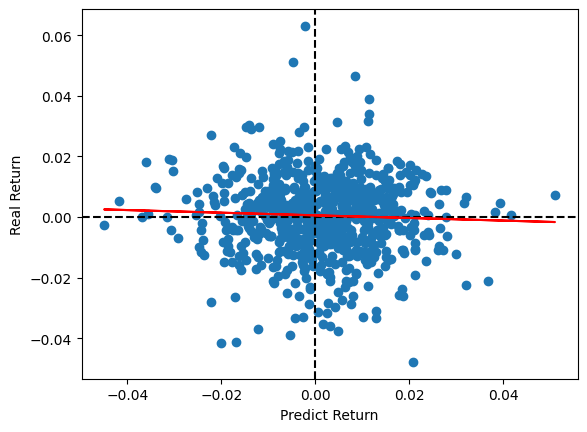

In [202]:
df_result = pd.DataFrame()
train_unit = 252
test_unit = 25
start = 0
for i in tqdm(range((train_unit+test_unit),len(df),test_unit)):
    duration = df_merge.iloc[start:i]
    x_train = duration.iloc[:-test_unit][df_merge.iloc[:,1:].columns]
    y_train = duration.iloc[:-test_unit]['y']
    x_test = duration.iloc[-test_unit:][df_merge.iloc[:,1:].columns]
    start += test_unit
    model1 = HistGradientBoostingRegressor(max_depth = 1, learning_rate=2).fit(x_train,y_train)
    predicted1 = model1.predict(x_test)
    model2 = HistGradientBoostingRegressor(max_depth = 2, learning_rate=2).fit(x_train,y_train)
    predicted2 = model2.predict(x_test)
    model3 = HistGradientBoostingRegressor(max_depth = 7, learning_rate=2).fit(x_train,y_train)
    predicted3 = model3.predict(x_test)
    predicted = (predicted1+predicted2+predicted3)/3
    for d in range(test_unit):
        day = duration.iloc[-test_unit:].index[d]
        predict = predicted[d]
        df_result.loc[day,'y'] = data.loc[day,'y']
        df_result.loc[day,'predict'] = predict 

df_result['y'] = data['y']
draw_distribution(df_result)
confusion_matrix(df_result)

const      0.518284
predict    0.054200
dtype: float64
Prevaience: 1.0
Accurancy:1.0
Precision:1.0
Recall:1.0
F1 Score: 1.0


ZeroDivisionError: division by zero

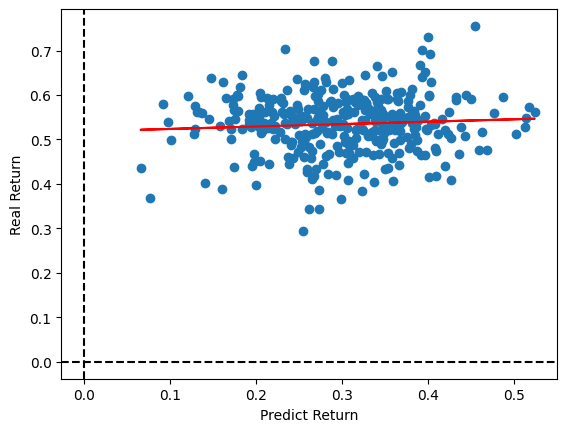

In [208]:
## value
# df = (df_merge - df_merge.mean())/df_merge.std()
df = (df_merge - df_merge.min())/(df_merge.max()-df_merge.min())
ratio = 0.7
df_train = df.iloc[:int(len(df)*ratio)]
df_test = df.iloc[int(len(df)*ratio):]
x_train = df_train[df_merge.iloc[:,1:].columns]
x_test = df_test[df_merge.iloc[:,1:].columns]

y_train = df_train['y']
y_test = df_test['y']
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# xgboostModel = XGBRegressor(max_depth = 3,n_estimators=600, learning_rate=2).fit(x_train,y_train)
# predicted = xgboostModel.predict(x_test)
xgboostModel1 = XGBRegressor(max_depth = 0,n_estimators=600, learning_rate=2).fit(x_train,y_train)
predicted1 = xgboostModel1.predict(x_test)
xgboostModel2 = XGBRegressor(max_depth = 2,n_estimators=600, learning_rate=2).fit(x_train,y_train)
predicted2 = xgboostModel2.predict(x_test)
xgboostModel3 = XGBRegressor(max_depth = 11,n_estimators=600, learning_rate=2).fit(x_train,y_train)
predicted3 = xgboostModel3.predict(x_test)
# xgboostModel4 = XGBRegressor(max_depth = 7,n_estimators=600, learning_rate=0).fit(x_train,y_train)
# predicted4 = xgboostModel4.predict(x_test)
# xgboostModel5 = XGBRegressor(max_depth = 7,n_estimators=600, learning_rate=2).fit(x_train,y_train)
# predicted5 = xgboostModel5.predict(x_test)
predicted = (predicted1+predicted2+predicted3)/5
df_boost = pd.DataFrame({'y':y_test,'predict':predicted})
draw_distribution(df_boost)
confusion_matrix(df_boost)

100%|██████████| 1021/1021 [05:35<00:00,  3.04it/s]

                   y   predict
2020-07-02 -0.002241  0.022401
2020-07-06  0.010439  0.007373
2020-07-07 -0.003830 -0.012677
2020-07-08  0.008825  0.006937
2020-07-09  0.000722 -0.005366
...              ...       ...
2024-07-24 -0.021571 -0.000361
2024-07-25 -0.012479  0.003950
2024-07-26 -0.000209 -0.002522
2024-07-29 -0.005282 -0.003555
2024-07-30 -0.016868  0.004700

[1021 rows x 2 columns]
const      0.000358
predict   -0.036292
dtype: float64
Prevaience: 0.5504407443682664
Accurancy:0.49559255631733595
Precision:0.5423423423423424
Recall:0.5355871886120996
F1 Score: 0.5389435989256939
Accurancy of No : 0.4466230936819172
-------Accuracy-----------
normal : 0.4779627815866797
abnormal : 0.01762977473065622
             Real Yes   Real No
Predict Yes  0.294809  0.248776
Predict No   0.255632  0.200784
92 929
Accuracy of abnormal: 0.45652173913043476
Accuracy of normal: 0.49946178686759957


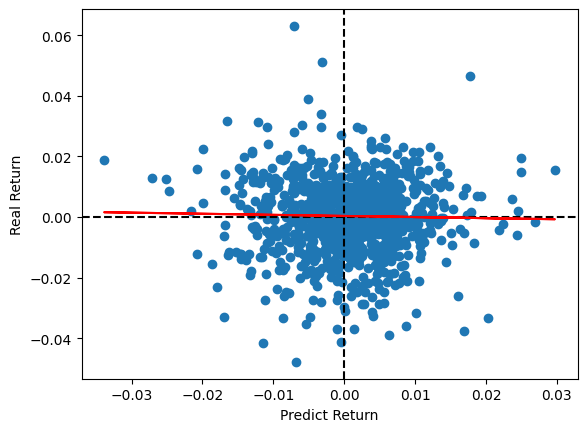

In [211]:
from sklearn.neighbors import RadiusNeighborsRegressor
df_result = pd.DataFrame()
train_unit = 122
test_unit = 1
start = 0
for i in tqdm(range((train_unit),len(df_merge))):
    # print(start,i)
    duration = df_merge.iloc[start:i]
    x_train = duration.iloc[:-test_unit][df_merge.iloc[:,1:].columns]
    y_train = duration.iloc[:-test_unit]['y']
    x_test = duration.iloc[-test_unit:][df_merge.iloc[:,1:].columns]
    start += 1
    # print(duration.iloc[0].name,duration.iloc[-1].name,len(duration),duration.iloc[-test_unit-1].name)
    model1 = HistGradientBoostingRegressor(max_depth = 1, learning_rate=2).fit(x_train,y_train)
    predicted1 = model1.predict(x_test)
    model2 = HistGradientBoostingRegressor(max_depth = 2, learning_rate=2).fit(x_train,y_train)
    predicted2 = model2.predict(x_test)
    model3 = HistGradientBoostingRegressor(max_depth = 7, learning_rate=2).fit(x_train,y_train)
    predicted3 = model3.predict(x_test)
    model4 = XGBRegressor(max_depth = 13, learning_rate=2).fit(x_train,y_train)
    predicted4 = model4.predict(x_test)
    model5 = XGBRegressor(max_depth = 2, learning_rate=2).fit(x_train,y_train)
    predicted5 = model5.predict(x_test)
    model6 = RadiusNeighborsRegressor(radius=1.7).fit(x_train,y_train)
    predicted6 = model6.predict(x_test)
    model7 = RadiusNeighborsRegressor(radius=1.4).fit(x_train,y_train)
    predicted7 = model7.predict(x_test)
    predicted6 = np.nan_to_num(predicted6,nan=np.mean(y_train[-5:]))
    predicted7 = np.nan_to_num(predicted7,nan=np.mean(y_train[-5:]))
    predicted = (predicted1+predicted2+predicted3+predicted4+predicted5+predicted6+predicted7)/7
    # predicted =predicted6
    for d in range(test_unit):
        day = duration.iloc[-test_unit:].index[d]
        predict = predicted[d]
        df_result.loc[day,'y'] = data.loc[day,'y']
        df_result.loc[day,'predict'] = predict 

df_result['y'] = data['y']
print(df_result)
draw_distribution(df_result)
acc_matrix = confusion_matrix(df_result)
print(acc_matrix)
abnormal = df_result[abs(df_result['y'])>0.02]
normal = df_result[abs(df_result['y'])<=0.02]
print(len(abnormal),len(normal))
accuracy_ab = (len(abnormal[abnormal['accuracy']=='TP'])+len(abnormal[abnormal['accuracy']=='TN']))/len(abnormal)
accuracy = (len(normal[normal['accuracy']=='TP'])+len(normal[normal['accuracy']=='TN']))/len(normal)
print(f'Accuracy of abnormal: {accuracy_ab}')
print(f'Accuracy of normal: {accuracy}')



const      0.000402
predict   -0.009210
dtype: float64
Prevaience: 0.5240594925634295
Accurancy:0.5188101487314086
Precision:0.542608695652174
Recall:0.5208681135225376
F1 Score: 0.5315161839863713
Accurancy of No : 0.5165441176470589
-------Accuracy-----------
normal : 0.4925634295713036
abnormal : 0.026246719160104987


,Real Yes,Real No
Predict Yes,0.272966,0.230096
Predict No,0.251094,0.245844


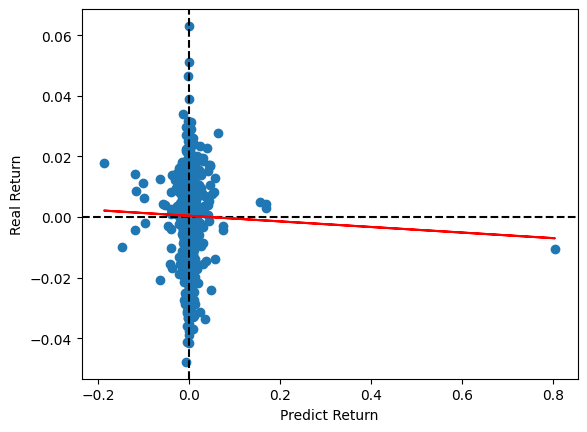

In [115]:
draw_distribution(df)
confusion_matrix(df)

array([[<Axes: title={'center': 'NVDA'}>,
        <Axes: title={'center': 'META'}>,
        <Axes: title={'center': 'AVGO'}>,
        <Axes: title={'center': 'NFLX'}>,
        <Axes: title={'center': 'ISRG'}>,
        <Axes: title={'center': 'TTD'}>,
        <Axes: title={'center': 'KLAC'}>,
        <Axes: title={'center': 'REGN'}>,
        <Axes: title={'center': 'COST'}>,
        <Axes: title={'center': 'FTNT'}>],
       [<Axes: title={'center': 'CTAS'}>,
        <Axes: title={'center': 'MELI'}>,
        <Axes: title={'center': 'AMAT'}>, <Axes: title={'center': 'MU'}>,
        <Axes: title={'center': 'AZN'}>,
        <Axes: title={'center': 'PANW'}>,
        <Axes: title={'center': 'TMUS'}>,
        <Axes: title={'center': 'ASML'}>,
        <Axes: title={'center': 'AEP'}>,
        <Axes: title={'center': 'GOOG'}>],
       [<Axes: title={'center': 'VRTX'}>,
        <Axes: title={'center': 'GOOGL'}>,
        <Axes: title={'center': 'QCOM'}>,
        <Axes: title={'center': 'TXN'}>,
   

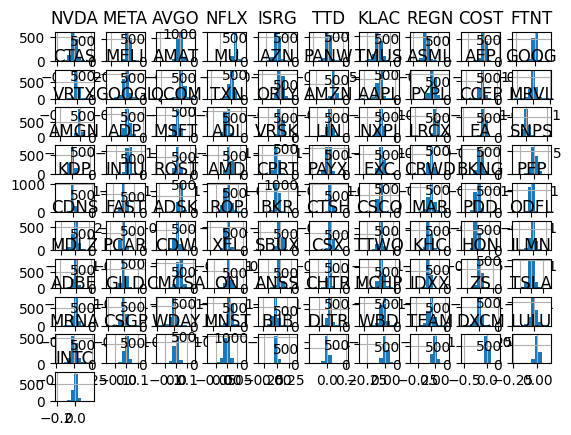

In [116]:
df_log_ret.hist()

In [188]:
# dj = yf.download('^DJI',progress=False)['Close']
# sp500 = yf.download('^GSPC',progress=False)['Close']
dj = yf.download('^DJI',progress=False)[['Close','Open']]
dj = dj['Close']/dj['Open'] -1
sp500 = yf.download('^GSPC',progress=False)[['Close','Open']]
sp500 = sp500['Close']/sp500['Open'] -1
ftse = yf.download('^FTSE',progress=False)[['Close','Open']]
ftse = ftse['Close']/ftse['Open'] -1
tnx = yf.download('^TNX',progress=False)[['Close','Open']]
tnx = tnx['Close']/tnx['Open'] -1
fvx = yf.download('^FVX',progress=False)[['Close','Open']]
fvx = fvx['Close']/fvx['Open'] -1
vix = yf.download('^VIX',progress=False)[['Close','Open']]
vix = vix['Close']/vix['Open'] -1
gld = yf.download('GLD',progress=False)[['Close','Open']]
gld = gld['Close']/gld['Open'] -1
ndx = yf.download('^NDX',progress=False)[['Close','Open']]
ndx = ndx['Close']/ndx['Open'] -1
twii =  yf.download('^TWII',progress=False)[['Close','Open']]
twii = twii['Close']/twii['Open'] -1
tsm =  yf.download('2330.TW',progress=False)[['Close','Open']]
tsm = tsm['Close']/tsm['Open'] -1
asml = yf.download('ASML',progress=False)[['Close','Open']]
asml = asml['Close']/asml['Open'] -1
tsla = yf.download('TSLA',progress=False)[['Close','Open']]
tsla = tsla['Close']/tsla['Open'] -1
ss01 = yf.download('EURUSD=X',progress=False)[['Close','Open']]
ss01 = ss01['Close']/ss01['Open'] -1

df = pd.concat([data['y'],dj,sp500,ftse,tnx,fvx,vix,gld,ndx,twii,tsm,asml,tsla,ss01],axis=1).dropna()
df.columns = ['y','DJ','SP500','FTSE','TNX','FVX','VIX','GLD','NDX','TWII','TSM','ASML','TSLA','SS01']
# df['DJ'] = df['DJ'].pct_change().shift(1)
# df['SP500'] = df['SP500'].pct_change().shift(1)
df['DJ'] = df['DJ'].shift(1)
df['SP500'] = df['SP500'].shift(1)
df['FTSE'] = df['FTSE'].shift(1)
df['TNX'] = df['TNX'].shift(1)
df['FVX'] = df['FVX'].shift(1)
df['VIX'] = df['VIX'].shift(1)
df['GLD'] = df['GLD'].shift(1)
df['NDX'] = df['NDX'].shift(1)
df['ASML'] = df['ASML'].shift(1)
df['TSLA'] = df['TSLA'].shift(1)
df['SS01'] = df['SS01'].shift(1)
df.corr()

,y,DJ,SP500,FTSE,TNX,FVX,VIX,GLD,NDX,TWII,TSM,ASML,TSLA,SS01
y,1.000000,-0.114628,-0.109626,-0.080500,0.026094,0.002683,0.106072,0.058307,-0.090395,0.039253,0.060452,-0.031220,-0.059341,-0.060811
DJ,-0.114628,1.000000,0.931919,0.415371,0.088119,0.068973,-0.618263,0.121104,0.714762,0.157113,-0.092296,0.532775,0.304211,0.039354
SP500,-0.109626,0.931919,1.000000,0.349094,0.074614,0.053740,-0.669732,0.119130,0.883647,0.169113,-0.095481,0.679848,0.450513,0.030793
FTSE,-0.080500,0.415371,0.349094,1.000000,-0.000754,0.025314,-0.261132,0.040331,0.102642,0.147920,-0.099278,0.093451,0.061581,0.042653
TNX,0.026094,0.088119,0.074614,-0.000754,1.000000,0.885968,-0.063467,-0.252466,0.093819,-0.097220,-0.048433,0.004307,0.019712,-0.004494
FVX,0.002683,0.068973,0.053740,0.025314,0.885968,1.000000,-0.000398,-0.248392,0.073369,-0.087539,-0.040995,-0.000176,0.018271,-0.069607
VIX,0.106072,-0.618263,-0.669732,-0.261132,-0.063467,-0.000398,1.000000,-0.080384,-0.593079,-0.220044,0.018149,-0.456081,-0.328505,-0.038309
GLD,0.058307,0.121104,0.119130,0.040331,-0.252466,-0.248392,-0.080384,1.000000,0.107591,0.116595,0.011136,0.199853,0.063024,-0.003559
NDX,-0.090395,0.714762,0.883647,0.102642,0.093819,0.073369,-0.593079,0.107591,1.000000,0.149916,-0.058465,0.775409,0.591174,0.035575
TWII,0.039253,0.157113,0.169113,0.147920,-0.097220,-0.087539,-0.220044,0.116595,0.149916,1.000000,0.690162,0.189588,0.150385,0.091882
